# Notebook to evaluate Sentinel-1 NRB sample product

In [8]:
# from zipfile import ZipFile
# import os, glob

# os.chdir('s1_sample/')
# fs = glob.glob('*.zip')
# fs

In [7]:
# with ZipFile(fs[0], 'r') as zipObj:
#    # Extract all the contents of zip file in current directory
#    zipObj.extractall()

# os.chdir('../')

In [ ]:
#!ls s1_sample/N00E016/2020/09/23/04031D/

In [ ]:
# from shapely import geometry

# geometry.shape(json.load(open('s1_sample/N00E016/2020/09/23/04031D/s1_nrb_04031D_N00E016_2020_09_23_metadata.json'))['geometry'])

In [4]:
%matplotlib inline

import glob
import json
import os

import datacube
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

## Check Sentinel-1 NRB sample product

In [9]:
#urban
#im = xr.open_rasterio('s1_sample/38N_PROB.tif', chunks={'x':1000, 'y':1000})
#im.isel(x=slice(0,10000,10), y = slice(0,10000,10)).squeeze().plot.imshow(robust=True);

### Load S1 sample data

In [23]:
def load_s1_sample_combined(s1_sample_path, band):
    fnames = glob.glob(f"{s1_sample_path}/**/*_{band}.tif", recursive=True)
    data = []
    for fname in fnames:
        meta = fname.replace(f"_{band}.tif", "_metadata.json")
        date = np.datetime64(json.load(open(meta))["properties"]["datetime"][:13])
        # print(fname, date)
        data.append(
            xr.open_rasterio(fname, chunks={"x": 1000, "y": 1000})
            .squeeze()
            .to_dataset(name=band)
            .expand_dims({"time": [date]})
        )
    dtype = data[0][band].dtype
    return xr.combine_by_coords(data).astype(dtype).sortby("time")

def load_s1_sample_combined(s1_sample_path, band):
    fname = glob.glob(f"{s1_sample_path}/*{band}.tif")[0]
    return xr.open_rasterio(fname, chunks={"x": 1000, "y": 1000}).squeeze().to_dataset(name=band)

In [17]:
# sinergise sample

def load_s1_sample(s1_sample_path, band):
    fnames = glob.glob(f"{s1_sample_path}/*/{band}.tiff")
    data = [xr.open_rasterio(fname).squeeze().to_dataset(name=band) for fname in fnames]
    dtype = data[0][band].dtype
    return xr.combine_by_coords(data).astype(dtype)

In [52]:
# sample data processed by GAMMA

def load_gamma_processed(s1_sample_path='s1_sample/Gamma_cm-zsz_S1-IW_Cop30_20200916_Addis/'):
    bands = {"VV":"VV", "VH":"VH", "MASK":"layover-shadow", "AREA":"pixel-area-norm", "ANGLE":"linc"}
    data = []
    for band in bands.keys():
        fname = glob.glob(f"{s1_sample_path}/*{bands[band]}*.tif")[0]
        data.append(xr.open_rasterio(fname).squeeze().to_dataset(name=band))
    return xr.combine_by_coords(data)

gamma_processed  = load_gamma_processed()
gamma_processed['VV'] = gamma_processed.VV.where(gamma_processed.MASK>0)**2
gamma_processed['VH'] = gamma_processed.VH.where(gamma_processed.MASK>0)**2
gamma_processed['AREA'] = gamma_processed.AREA.where(gamma_processed.MASK>0)
gamma_processed['ANGLE'] = gamma_processed.ANGLE.where(gamma_processed.MASK>0)*180./np.pi

In [62]:
bands = ["VV", "VH", "MASK", "AREA", "ANGLE"]
#Douala, Cameroon
#s1_sample_path = "s1_sample/N0[234]E???"
#Likouala
#s1_sample_path = "s1_sample/?0[012]E01[678]"
#Addis
s1_sample_path = "s1_sample/N0[789]E???"
bands = ["VV", "MASK", "AREA", "ANGLE"]
s1_sample_path = "s1_sample/Addis_ETH_Bilinear_Shifted_Amplitude"

data = []
for band in bands:
    print(band)
    data.append(load_s1_sample_combined(s1_sample_path, band))
    
combined = xr.combine_by_coords(data)#.sortby('time').squeeze()
combined['VV'] = combined.VV**2
combined['ANGLE'] = combined.ANGLE.where(combined.ANGLE!=255)#*360./254.255

VV
MASK
AREA
ANGLE


In [ ]:
# subset to scene coverage
combined = combined.sel(x=gamma_processed.x.values-0.0001, y = gamma_processed.y.values+0.0001, method='nearest',tolerance=1e-5)

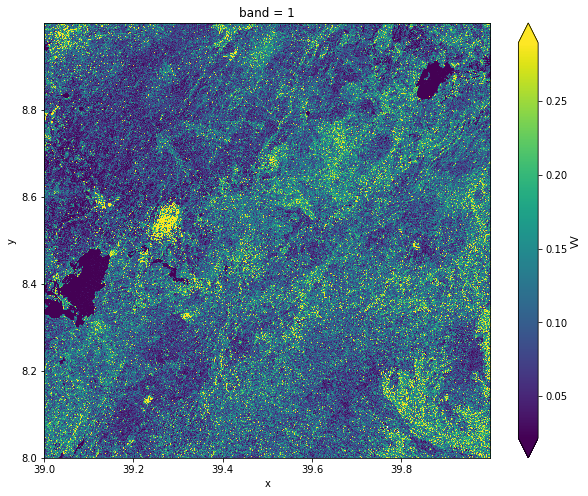

In [63]:
combined.VV.plot.imshow(robust=True, figsize=(10,8));

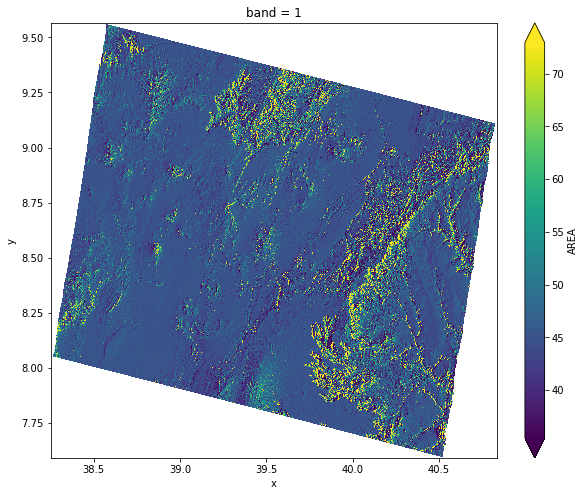

In [255]:
(np.arctan(1./gamma_processed.AREA)*180./np.pi).plot.imshow(robust=True, figsize=(10,8));

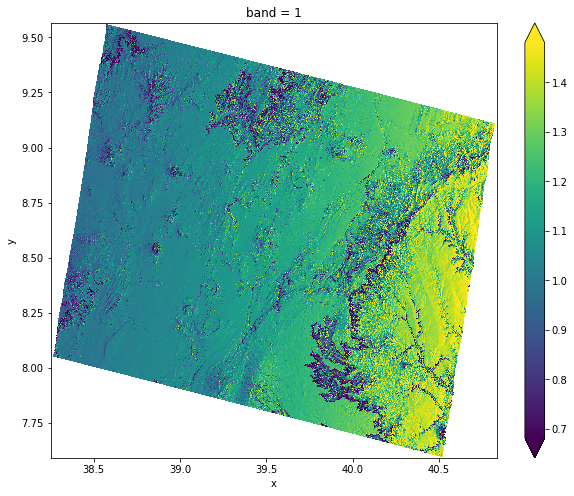

In [260]:
(np.arctan(gamma_processed.AREA)*180./np.pi/gamma_processed.ANGLE).plot.imshow(figsize=(10,8), robust=True);

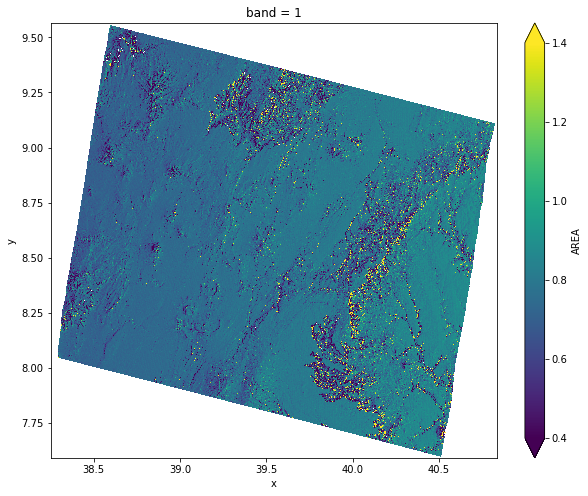

In [253]:
(gamma_processed.AREA*combined.AREA.values).plot.imshow(robust=True, figsize=(10,8), vmin=0.4, vmax=1.4);

In [64]:
# Addis
lat, lon = 8.98, 38.76
s = 0.02
# Terrain
#lat, lon = 7.70, 39.9 # outside scene 
lat, lon = 7.9, 39.9
s = 0.03

# water and urban and crop
lat, lon = 8.46, 39.21
s=0.03

combined_sub = combined.squeeze().sel(x=slice(lon-s, lon+s), y = slice(lat+s, lat-s)).compute()
gamma_sub = gamma_processed.sel(x=combined_sub.x.values, y=combined_sub.y.values, method='nearest',tolerance=1e-5)
#combined = combined.isel(y=(combined.MASK.sum('x').values/len(combined.y))>0.7)
#combined = combined.isel(x=(combined.MASK.sum('y').values/len(combined.x))>0.7)

In [65]:
from skimage.registration import phase_cross_correlation

phase_cross_correlation(combined_sub.ANGLE.values, gamma_sub.ANGLE.values, upsample_factor=100)

(array([0., 0.]), 0.018126288750067217, -2.015049131111683e-16)

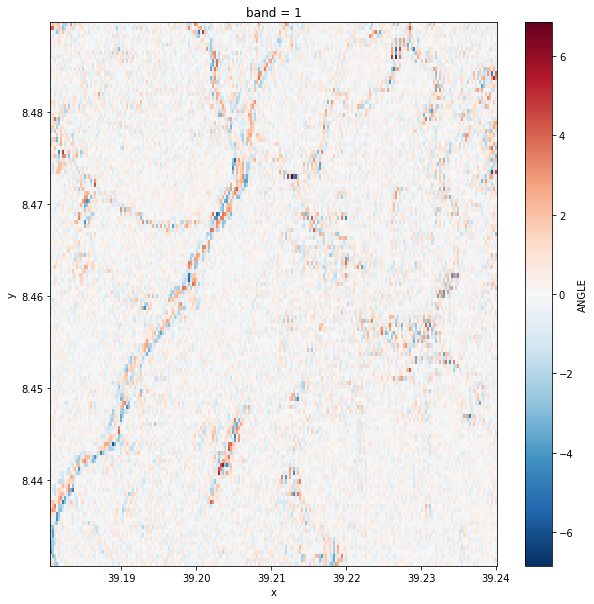

In [66]:
(gamma_sub-combined_sub).ANGLE.plot.imshow(figsize=(10,10));

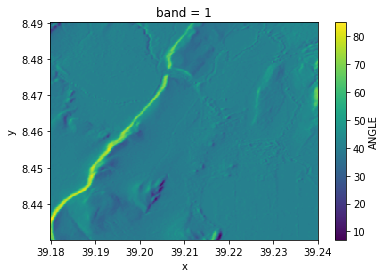

In [55]:
combined_sub.ANGLE.plot.imshow();

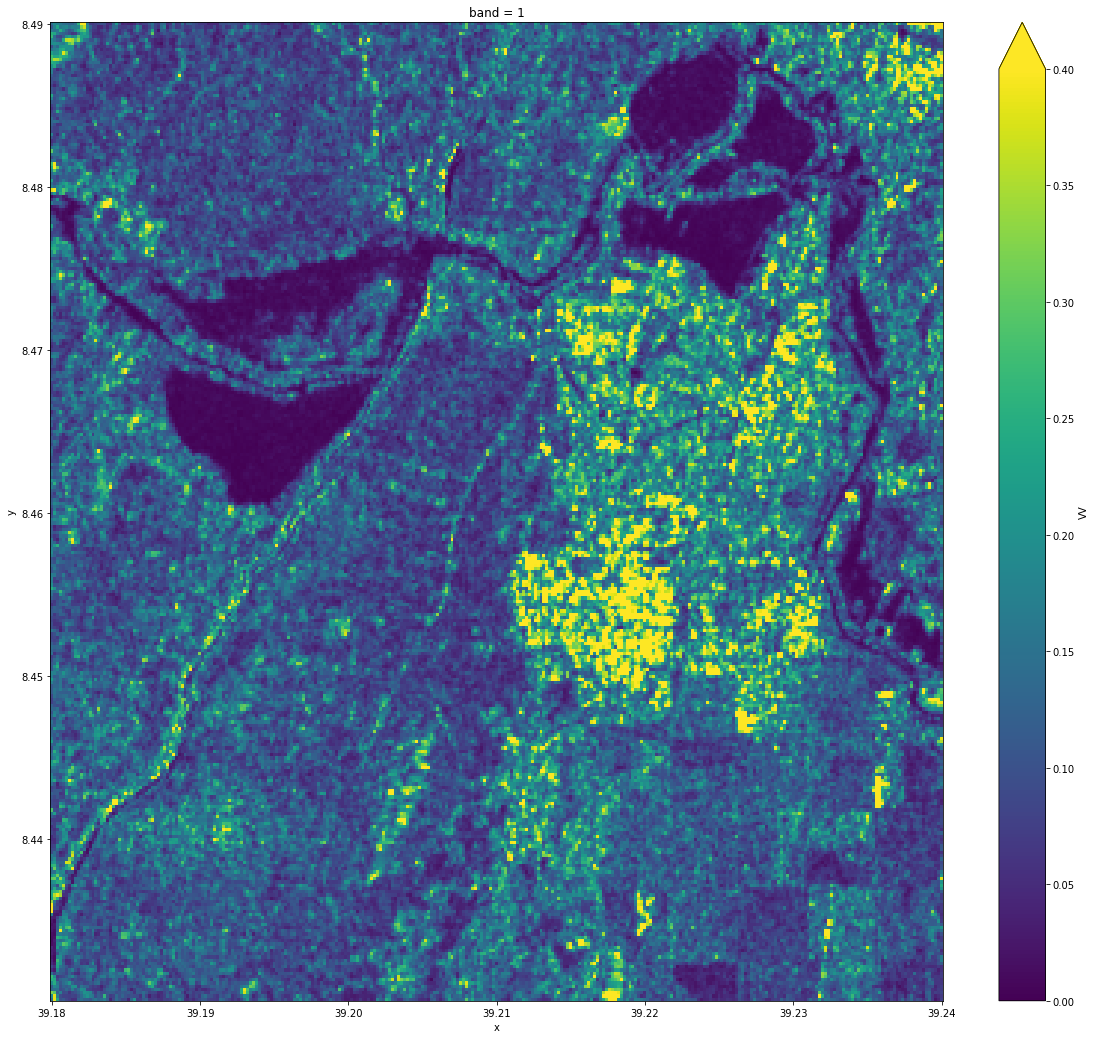

In [73]:
(combined_sub.VV).plot.imshow(figsize=(20,18), robust=True, vmin=0, vmax=0.4);

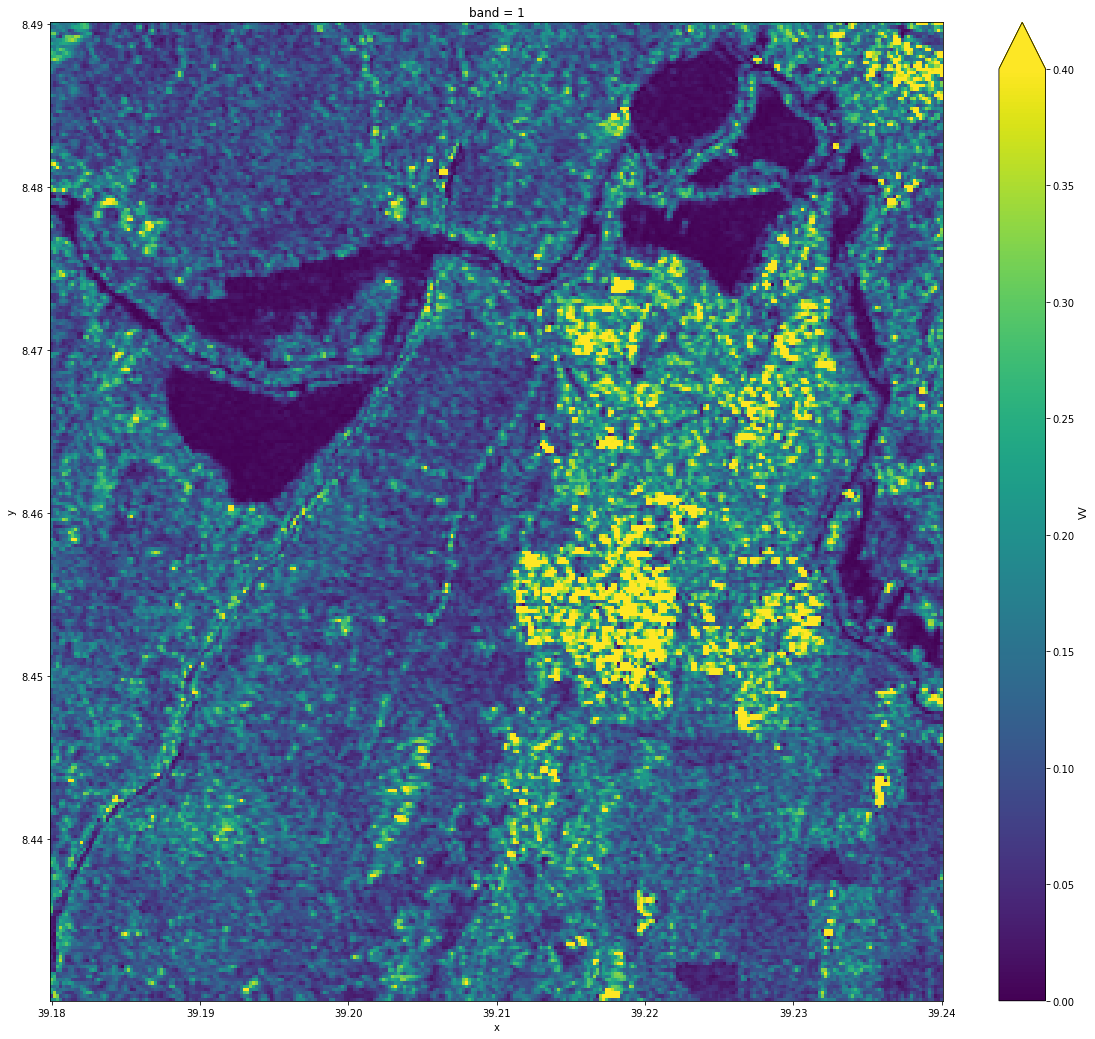

In [74]:
(gamma_sub.VV).plot.imshow(figsize=(20,18), robust=True, vmin=0, vmax=0.4);

In [245]:
combined_sub['VH_VV'] = (combined_sub.VH/combined_sub.VV/2).compute()
combined_sub['VH_5'] = (combined_sub.VH*5).compute()

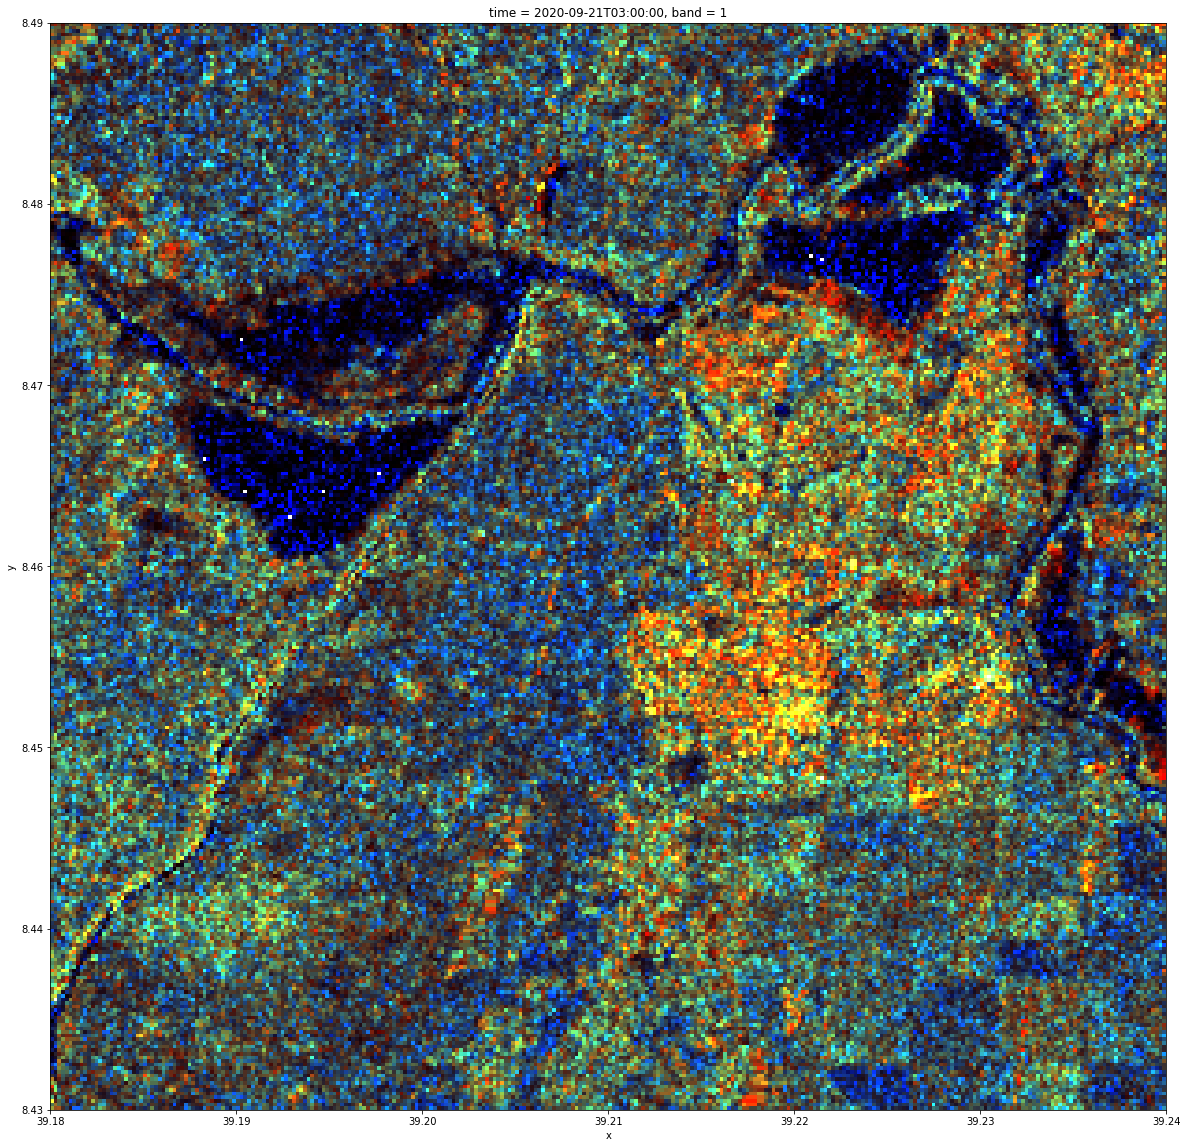

In [246]:

(combined_sub[['VV','VH_5','VH_VV']].to_array()).plot.imshow(robust=True, figsize=(20,20));

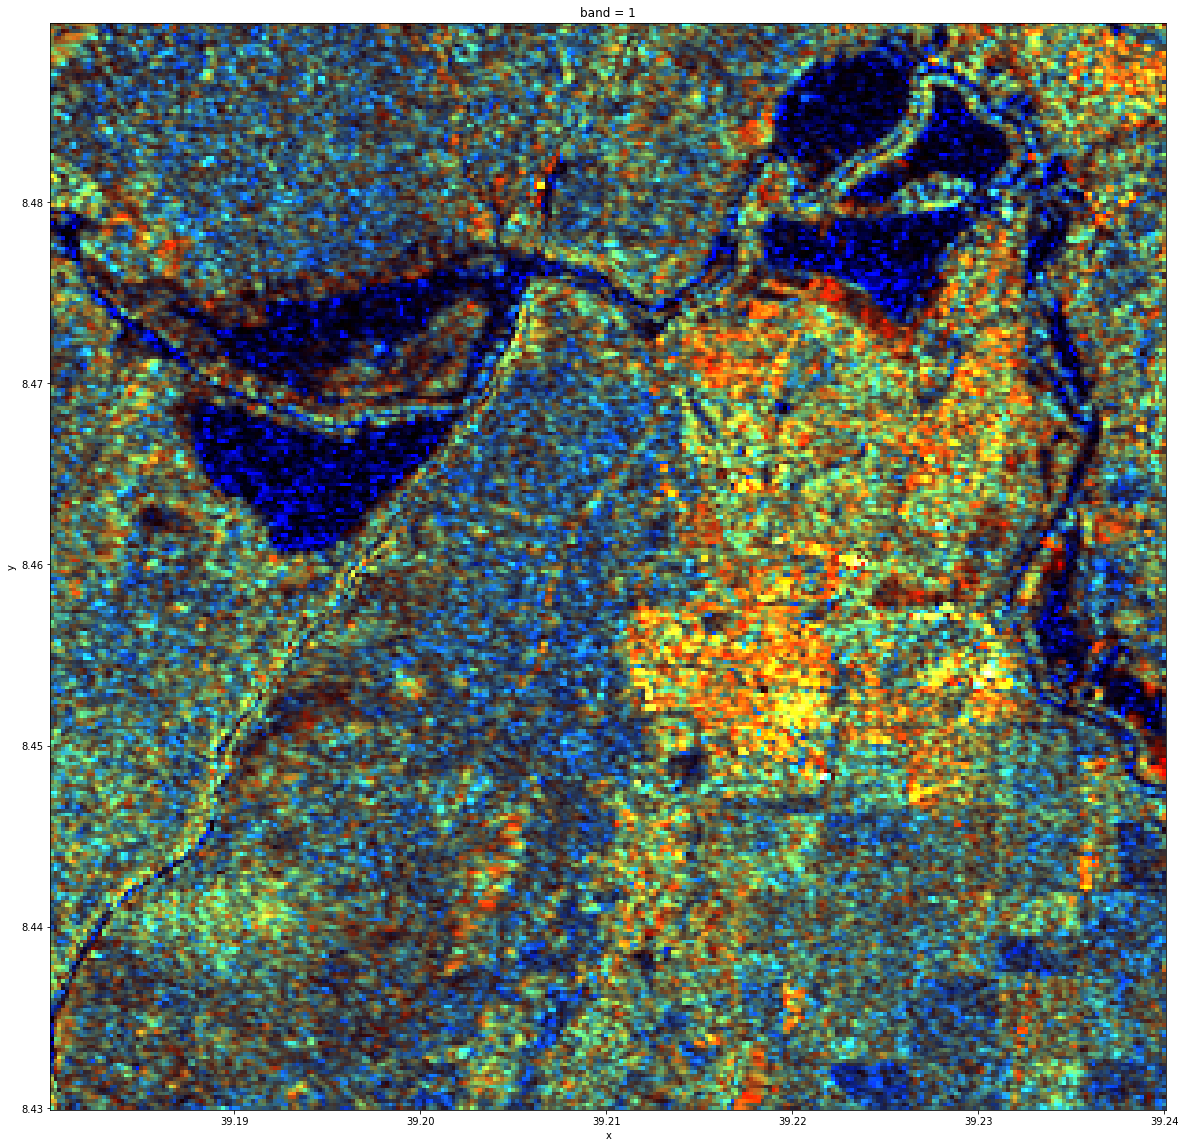

In [247]:
gamma_sub['VH_VV'] = (gamma_sub.VH/gamma_sub.VV/2)
gamma_sub['VH_5'] = (gamma_sub.VH*5)
(gamma_sub[['VV','VH_5','VH_VV']].to_array()).plot.imshow(robust=True, figsize=(20,20));

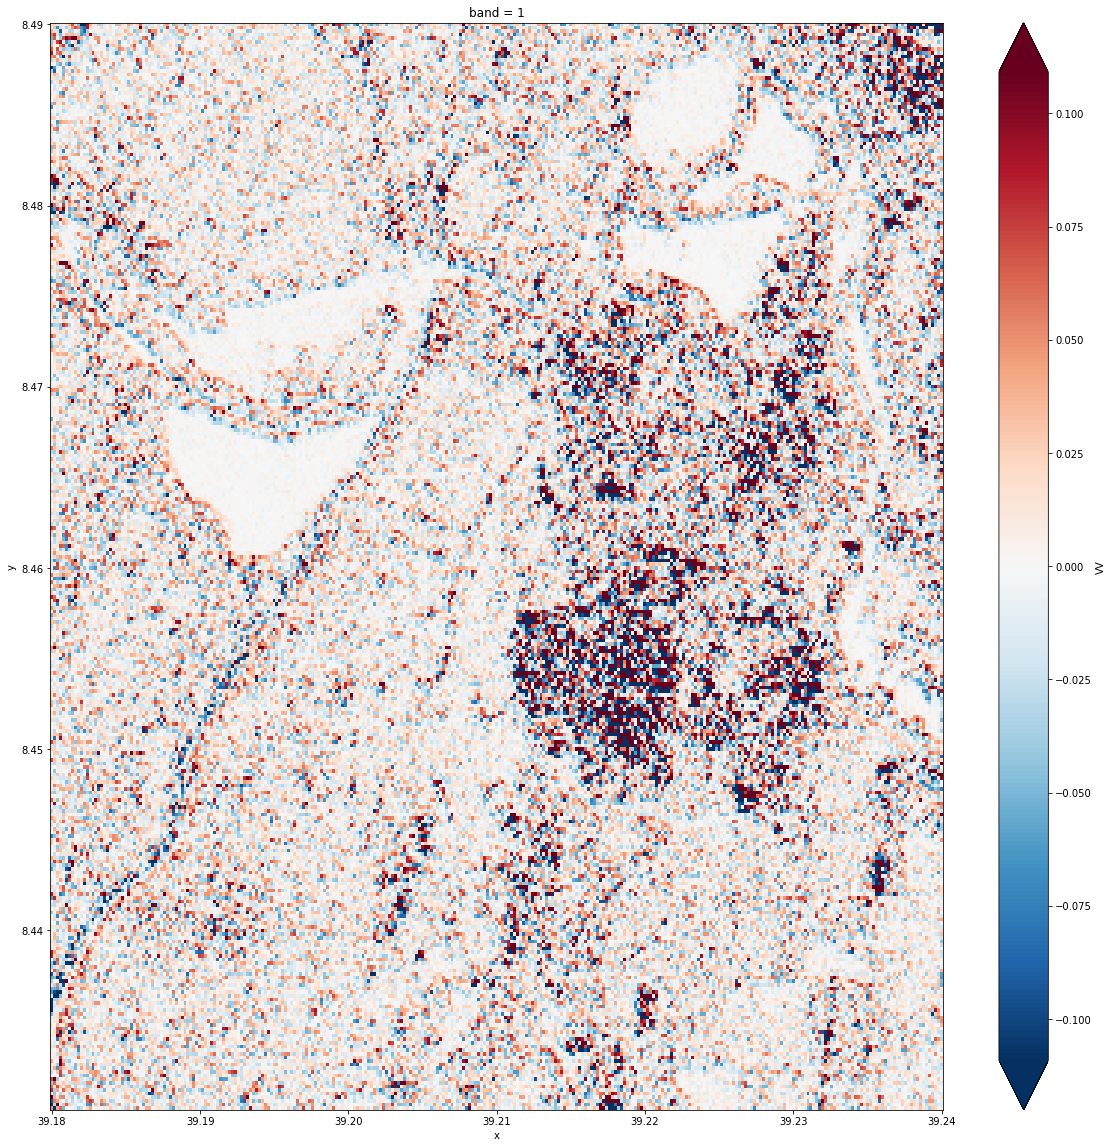

In [68]:
(gamma_sub.VV-combined_sub.VV.values).plot.imshow(robust=True, figsize=(20,20),);

In [69]:
combined_sub.VH.plot.hist(bins=np.arange(0, 1, 0.05), alpha=0.5);
gamma_sub.VH.plot.hist(bins=np.arange(0, 1, 0.05), alpha=0.5);


AttributeError: 'Dataset' object has no attribute 'VH'

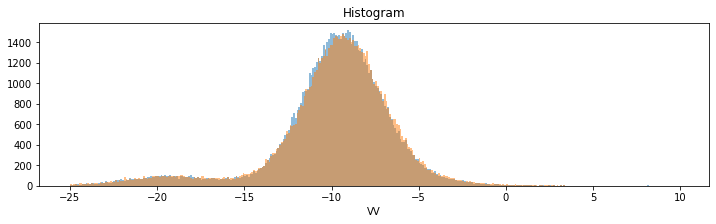

In [72]:
(10*np.log10(combined_sub.VV)).plot.hist(bins=np.arange(-25, 10, 0.1), alpha=0.5, figsize=(12,3));
(10*np.log10(gamma_sub.VV)).plot.hist(bins=np.arange(-25, 10, 0.1), alpha=0.5);

In [ ]:
# combined.VH.plot.imshow(col='time', robust=True);

In [ ]:
# combined.MASK.plot.imshow(col='time', robust=True);

In [ ]:
# combined.ANGLE.plot.imshow(col='time', robust=True);

In [ ]:
# combined.AREA.plot.imshow(col='time', robust=True);

### Effectiveness of RTC 

Assessment:
1. No strong dependence on angle is observed in VV and VH, hence the RTC appears to be effective.
2. Might be useful to check more areas with terrain.

### Load srtm 

Using SRTM to find area with elevation and potential slope, so slight mis-alignment is OK

In [103]:
dc = datacube.Datacube()

In [104]:
x = combined.x.values[0], combined.x.values[-1]
y = combined.y.values[0], combined.y.values[-1]
srtm = dc.load(product="srtm", x=x, y=y, resolution=(-0.0002, 0.0002)).squeeze()
srtm = srtm.rename({"latitude": "y", "longitude": "x"})
srtm["x"] = combined.x.values
srtm["y"] = combined.y.values

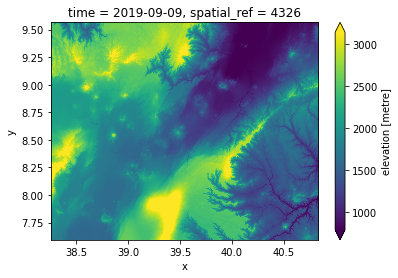

In [105]:
srtm.elevation.plot.imshow(robust=True);

In [ ]:
#high_elev = 150

In [ ]:
#srtm.where(srtm.elevation > high_elev).elevation.plot.imshow(robust=True);

### Load slope derived from SRTM

In [111]:
from datacube.utils.geometry import GeoBox, box, CRS
import rioxarray
from odc.algo import xr_reproject

def load_from_cog(url, name=None, resampling = 'nearest', chunks = dict(x=10_000, y=10_000), **kwargs):
    output_grid = kwargs.get('geobox')
    if output_grid is None:
        try:
            x = kwargs['x']
            y = kwargs['y']
            resolution = kwargs['resolution']
            output_crs = kwargs['output_crs']
            input_crs = kwargs.get('crs', 'EPSG:4326')
        except KeyError:
            print("x, y, resolution and output_crs are required if geobox is not supplied.")
            return
        # define output geometry
        gbox = box(x[0], y[0], x[1], y[1], crs = input_crs)
        # define output bounding box
        output_gbox = gbox.to_crs(crs=CRS(output_crs))
        # define output grid
        output_grid = GeoBox.from_geopolygon(output_gbox, resolution = resolution)

    img_all = rioxarray.open_rasterio(url, chunks=chunks).squeeze('band')
    if name is None: name = url.split('/')[-1].split('.')[0]
    img_all.name = name 
    return xr_reproject(img_all, output_grid, resampling=resampling).compute()

url = 'https://deafrica-data.s3-us-west-2.amazonaws.com/ancillary/dem-derivatives/cog_slope_africa.tif'

x = combined_sub.x.values[0], combined_sub.x.values[-1]
y = combined_sub.y.values[0], combined_sub.y.values[-1]
slope = load_from_cog(url, x=x, y=y, resolution=(-0.0002, 0.0002), output_crs = 'EPSG:4326')

In [112]:
# make sure coordinates matchs
slope= slope.rename({"latitude": "y", "longitude": "x"})
slope["x"] = combined_sub.x.values
slope["y"] = combined_sub.y.values

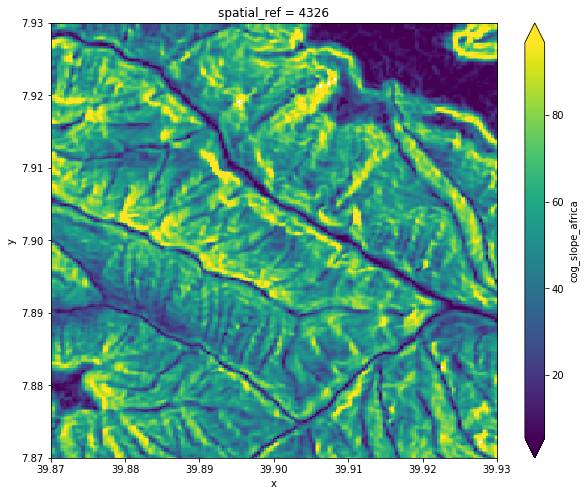

In [113]:
slope.where(combined_sub.MASK.values==1).plot.imshow(robust=True, figsize=(10,8));

In [114]:
high_slope = 20
print("fraction of high slope area", (slope>high_slope).mean().values)

fraction of high slope area 0.9148666666666667


In [115]:
combined_sub = combined_sub.where(combined_sub.MASK == 1)

In [158]:
combined_sub["VV_db"] = 10 * np.log10(combined_sub["VV"])
combined_sub["VH_db"] = 10 * np.log10(combined_sub["VH"])

/env/lib/python3.6/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


In [154]:
gamma_sub["VV_db"] = 10 * np.log10(gamma_sub["VV"])
gamma_sub["VH_db"] = 10 * np.log10(gamma_sub["VH"])
gamma_sub['x'] = combined_sub.x.values
gamma_sub['y'] = combined_sub.y.values


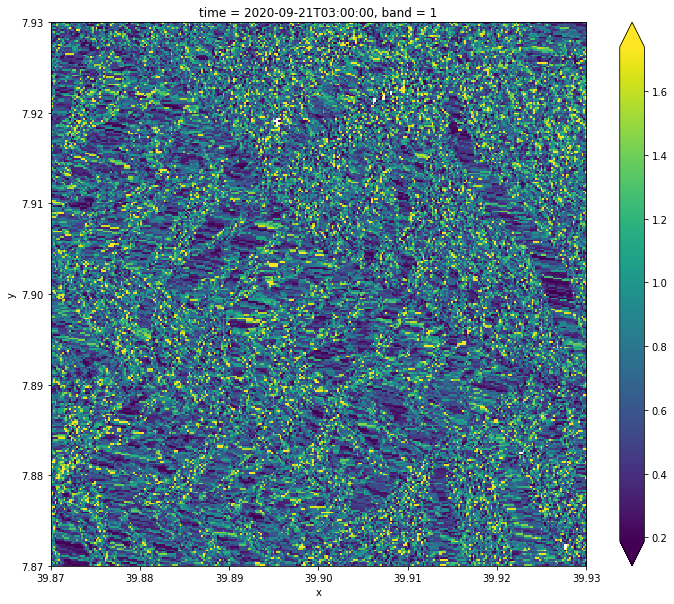

In [155]:
# vegetation index
veg = 4 * combined_sub.VH / (combined_sub.VH + combined_sub.VV)
veg.plot.imshow(robust=True, figsize=(12,10));

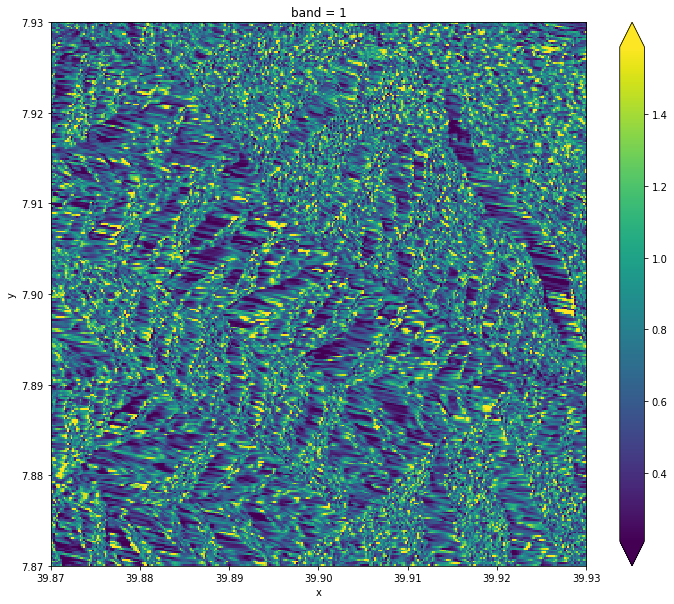

In [156]:
# vegetation index
veg_gamma = 4 * gamma_sub.VH / (gamma_sub.VH + gamma_sub.VV)
veg_gamma.plot.imshow(robust=True, figsize=(12,10));

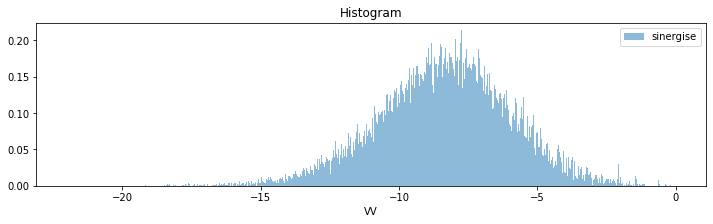

In [119]:
bins = np.arange(-22, 0, 0.01)
#(10 * np.log10(combined.VV.mean(dim="time"))).plot.hist(
#    bins=bins, alpha=0.5, density=True, figsize=(12, 3), label="sinergise"
#)
(10 * np.log10(combined_sub.VV)).plot.hist(
    bins=bins, alpha=0.5, density=True, figsize=(12, 3), label="sinergise"
)
plt.legend();

In [120]:
# super rough forest area estimate
forest = (veg > 1.) & (combined_sub.VV_db > -12)

In [121]:
print("# of pixels of high slope forest", forest.where(slope > high_slope, 0).mean().values)

# of pixels of high slope forest 0.1786888888888889


In [ ]:
#combined["ANGLE"].where(forest).where(slope > high_slope).plot.imshow(
#    col="time", robust=True
#);

Band:VV_db, slope=-0.007285728428819232, intercept=-9.183264641703964, r2=0.006938237541813774


/env/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10


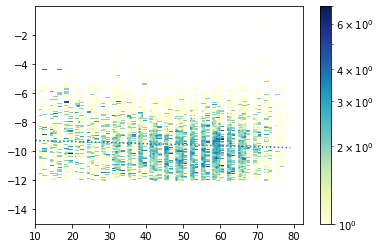

In [163]:
band = "VV_db"

arr1 = (combined_sub["ANGLE"].where(forest).where(slope > high_slope).values.flatten())
xedges = list(np.arange(10, 80, 1))
arr2 = combined_sub[band].where(forest).where(slope > high_slope).values.flatten()
yedges = list(np.arange(-15, 0, 0.01))
valid = (~np.isnan(arr1)) & (~np.isnan(arr2))
arr1, arr2 = arr1[valid], arr2[valid]

regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(arr1[:, np.newaxis], arr2[:, np.newaxis])
## The coefficients
print(
    "Band:{0}, slope={1}, intercept={2}, r2={3}".format(
        band,
        regr.coef_[0][0],
        regr.intercept_[0],
        regr.score(arr1[:, np.newaxis], arr2[:, np.newaxis]),
    )
)

X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
cmname = "YlGnBu"
hist, xe, ye = np.histogram2d(arr2, arr1, bins=(yedges, xedges))
plt.pcolor(X, Y, hist, cmap=cmname, norm=LogNorm(1, vmax=hist.max()))
plt.colorbar()
plt.contour(X, Y, np.log10(hist), cmap=cmname, levels=5)
plt.plot(xedges, regr.predict(np.array(xedges)[:, np.newaxis]), ":");

Band:VV_db, slope=-0.013865876942873001, intercept=-7.740253925323486, r2=0.01791889825711379


/env/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10


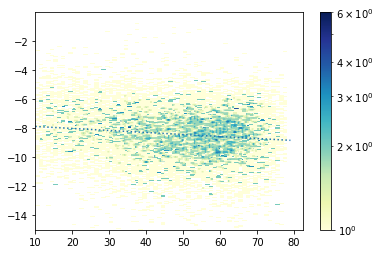

In [164]:
band = "VV_db"

arr1 = (gamma_sub["ANGLE"].where(forest).where(slope > high_slope).values.flatten())
xedges = list(np.arange(10, 80, 1))
arr2 = gamma_sub[band].where(forest).where(slope > high_slope).values.flatten()
yedges = list(np.arange(-15, 0, 0.01))
valid = (~np.isnan(arr1)) & (~np.isnan(arr2))
arr1, arr2 = arr1[valid], arr2[valid]

regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(arr1[:, np.newaxis], arr2[:, np.newaxis])
## The coefficients
print(
    "Band:{0}, slope={1}, intercept={2}, r2={3}".format(
        band,
        regr.coef_[0][0],
        regr.intercept_[0],
        regr.score(arr1[:, np.newaxis], arr2[:, np.newaxis]),
    )
)

X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
cmname = "YlGnBu"
hist, xe, ye = np.histogram2d(arr2, arr1, bins=(yedges, xedges))
plt.pcolor(X, Y, hist, cmap=cmname, norm=LogNorm(1, vmax=hist.max()))
plt.colorbar()
plt.contour(X, Y, np.log10(hist), cmap=cmname, levels=5)
plt.plot(xedges, regr.predict(np.array(xedges)[:, np.newaxis]), ":");

In [ ]:
band = "VH_db"

arr1 = (combined["ANGLE"].where(forest).where(slope > high_slope).values.flatten())
xedges = list(np.arange(10, 80, 1))
arr2 = combined[band].where(forest).where(slope > high_slope).values.flatten()
yedges = list(np.arange(-20, -5, 0.01))
valid = (~np.isnan(arr1)) & (~np.isnan(arr2))
arr1, arr2 = arr1[valid], arr2[valid]

regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(arr1[:, np.newaxis], arr2[:, np.newaxis])
## The coefficients
print(
    "Band:{0}, slope={1}, intercept={2}, r2={3}".format(
        band,
        regr.coef_[0][0],
        regr.intercept_[0],
        regr.score(arr1[:, np.newaxis], arr2[:, np.newaxis]),
    )
)

X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
cmname = "YlGnBu"
hist, xe, ye = np.histogram2d(arr2, arr1, bins=(yedges, xedges))
plt.pcolor(X, Y, hist, cmap=cmname, norm=LogNorm(1, vmax=hist.max()))
plt.colorbar()
plt.contour(X, Y, np.log10(hist), cmap=cmname, levels=5)
plt.plot(xedges, regr.predict(np.array(xedges)[:, np.newaxis]), ":");

### Compare to Sentinel-2 features



In [ ]:
dc = datacube.Datacube()

In [214]:
ds = dc.load(product = 's2_l2a', time=('2020-08', '2020-09'), group_by='solar_day', dask_chunks=dict(latitude=1000,longitude=1000), cloud_cover=(0,30),
             measurements=['blue','green','red','nir','swir_1', 'SCL'], like = combined_sub.geobox).squeeze().isel(time=2)

In [208]:
mask = ds.SCL.isin([2, 4, 5, 6, 7])
ds = ds.where(mask)

In [209]:
NDVI = (ds.green - ds.nir) / (ds.green + ds.nir)

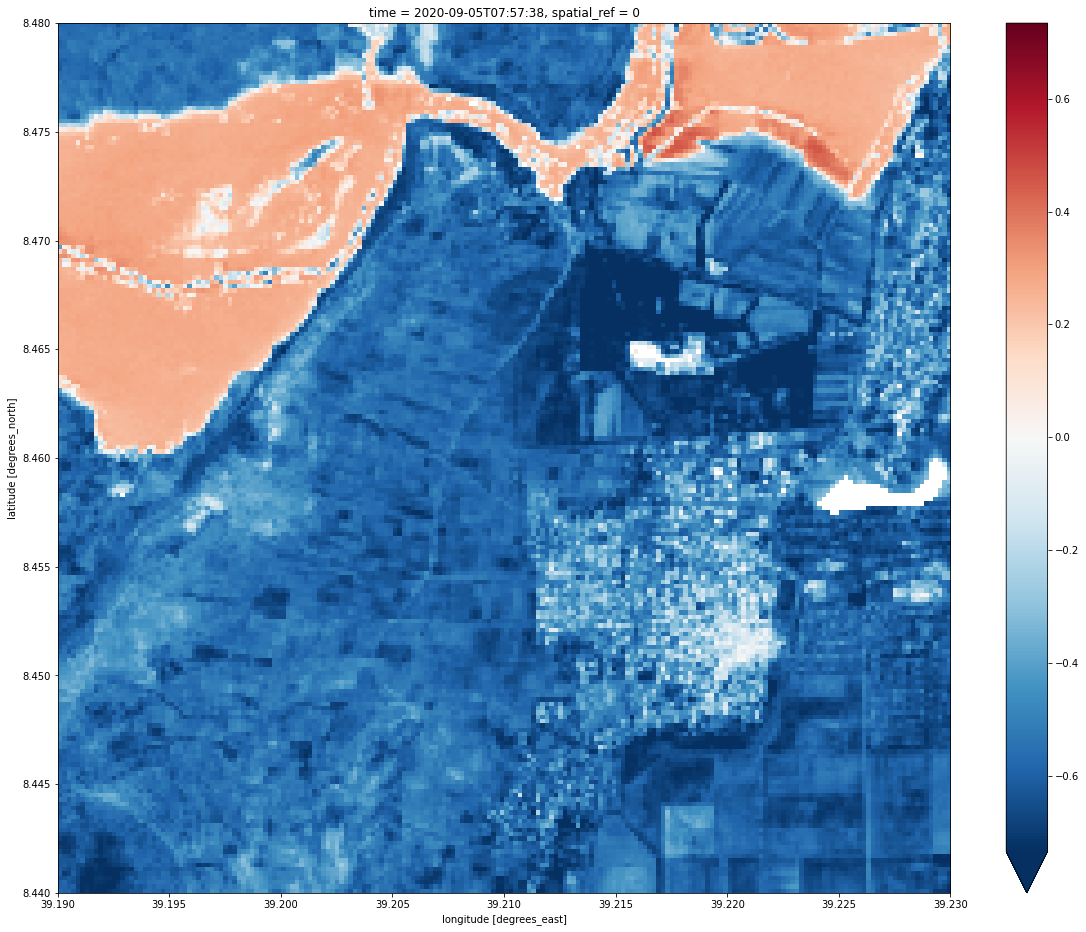

In [210]:
#s2[['red','green','blue']].to_array()
NDVI.plot.imshow(robust=True, figsize=(20,16));

In [211]:
#s2 = dc.load(product = 's2_l2a', time='2020-10', group_by='solar_day', dask_chunks=dict(latitude=1000,longitude=1000), cloud_cover=(0,10),
#             measurements=['blue','green','red','nir','swir_1'], like = combined_sub.geobox).squeeze()

In [219]:
ds.SCL.attrs

{'units': '1',
 'nodata': 0,
 'flags_definition': {'qa': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
   'values': {'0': 'no data',
    '1': 'saturated or defective',
    '2': 'dark area pixels',
    '3': 'cloud shadows',
    '4': 'vegetation',
    '5': 'bare soils',
    '6': 'water',
    '7': 'unclassified',
    '8': 'cloud medium probability',
    '9': 'cloud high probability',
    '10': 'thin cirrus',
    '11': 'snow or ice'},
   'description': 'Sen2Cor Scene Classification'}},
 'crs': '+init=epsg:4326',
 'grid_mapping': 'spatial_ref'}

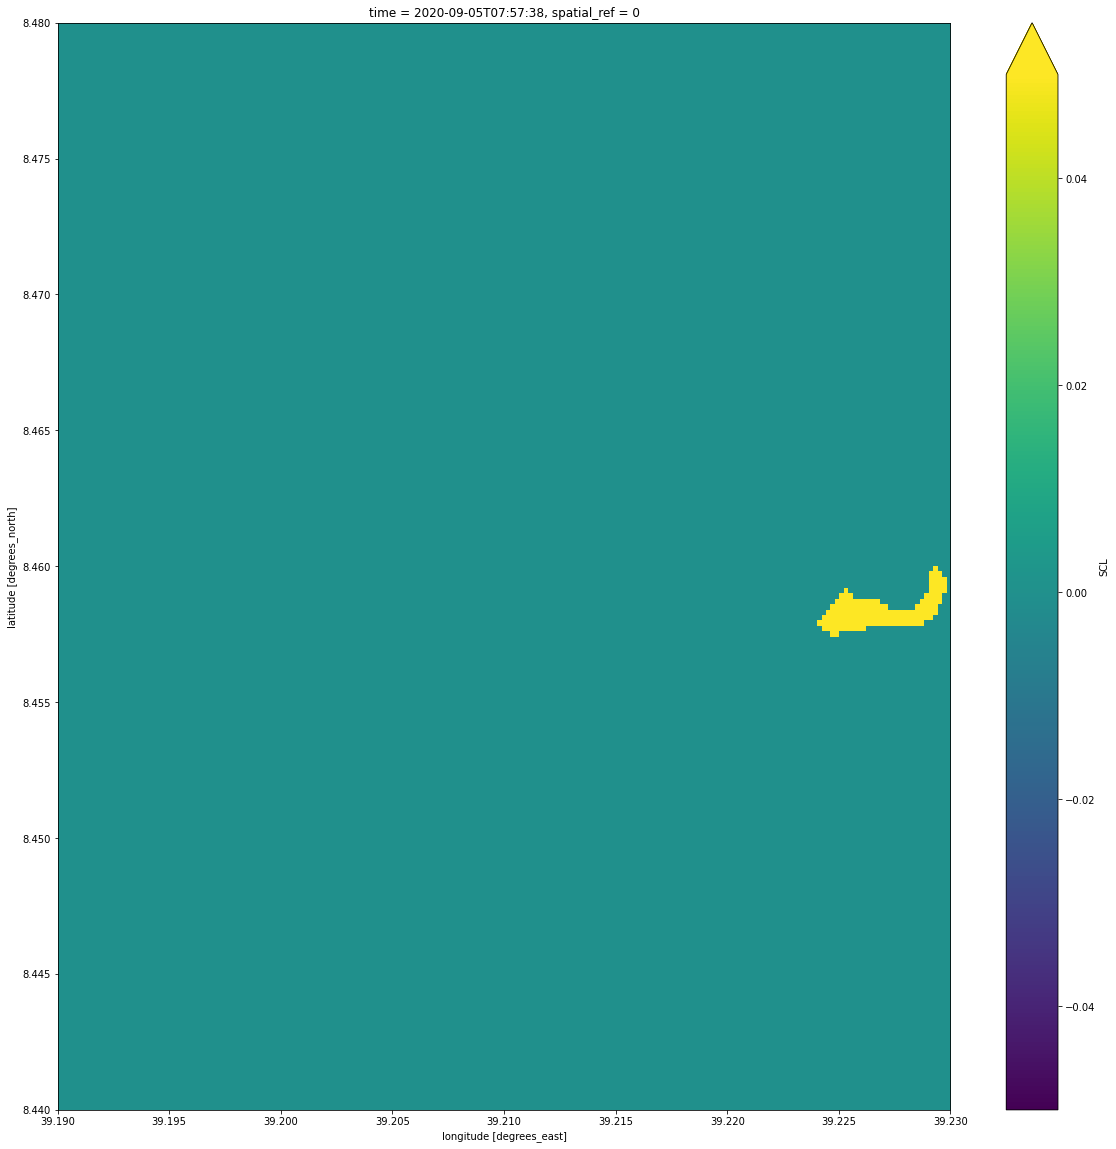

In [224]:
(ds.SCL==3).plot.imshow(robust=True, figsize=(20,20));

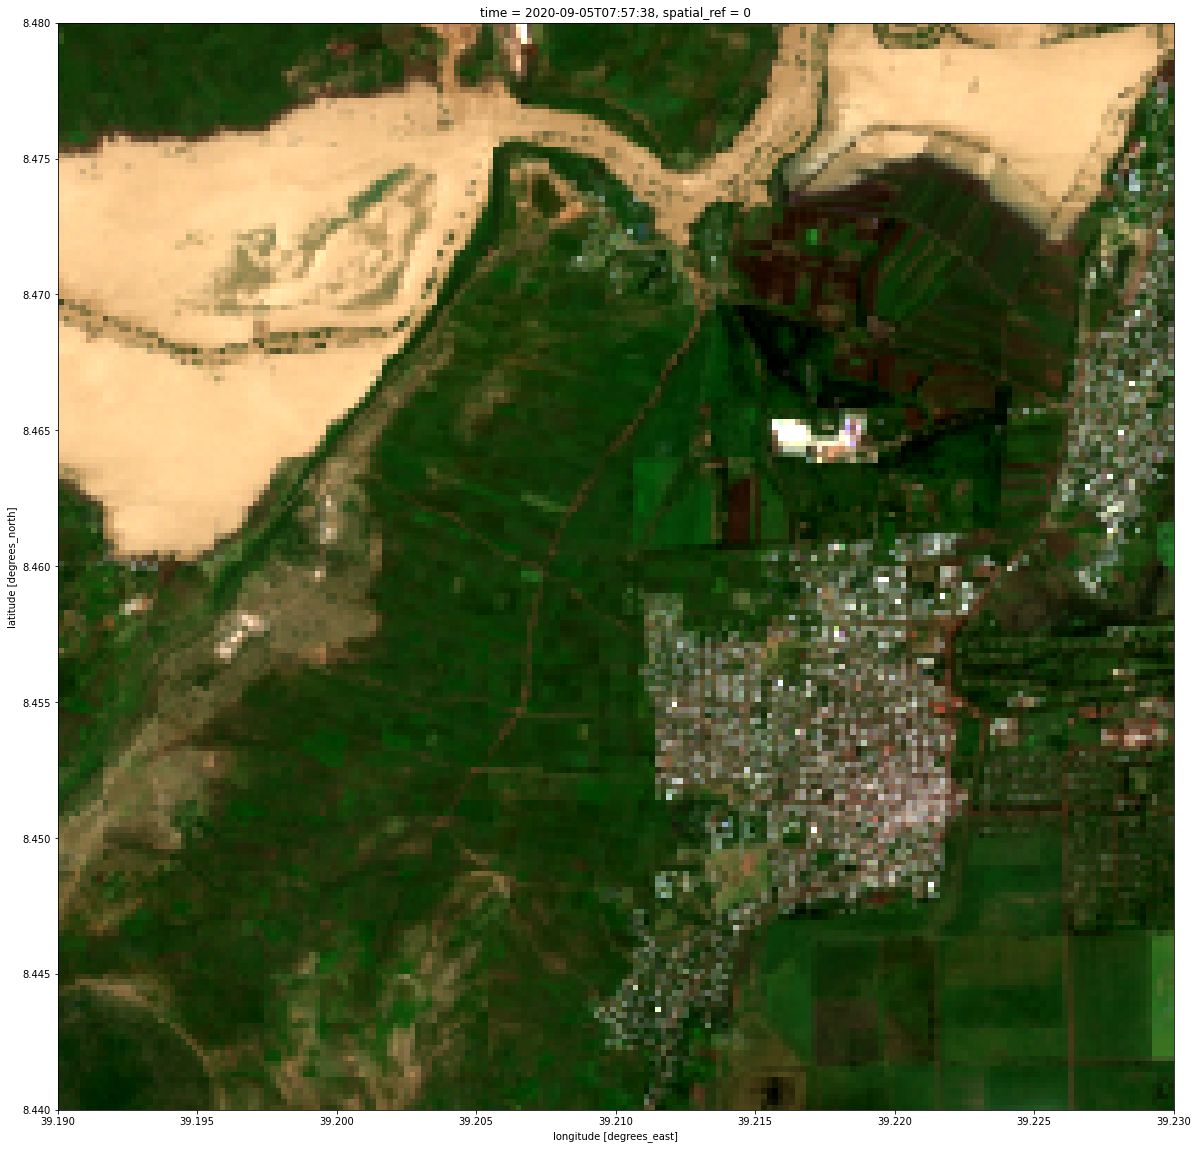

In [215]:
ds[['red','green','blue']].to_array().plot.imshow(robust=True, figsize=(20,20));

In [134]:
#gm = dc.load(product = 'ga_s2_gm', measurements=['blue','green','red','nir','swir_1'], like = combined.geobox).squeeze()

In [ ]:
#gm[['red','green','blue']].to_array().plot.imshow(robust=True, figsize=(20,20));

In [ ]:
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    Option to fill negative pixel with grey_dilation
    """
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    
    return img_output

combined['VV_filtered'] = ('y', 'x'), lee_filter(combined.VV.where(~np.isinf(combined.VV), 0).where(combined.VV.notnull(), 0), 5)
combined['VH_filtered'] = ('y', 'x'), lee_filter(combined.VH.where(~np.isinf(combined.VV), 0).where(combined.VH.notnull(), 0), 5)

In [ ]:
combined.VV_filtered.plot.imshow(robust=True, figsize=(20,20), add_colorbar=False);

In [ ]:
combined[['VV_filtered','VH_filtered','VV_VH']].

In [ ]:
combined['VV_VH'] = combined.VH_filtered/combined.VV_filtered/2
combined['VH_filtered_2']= combined.VH_filtered*5
combined[['VV_filtered','VH_filtered_2','VV_VH']].to_array().plot.imshow(robust=True, figsize=(20,20), add_colorbar=False);

In [ ]:
combined.VV_VH.plot.imshow(robust=True, figsize=(10,10), add_colorbar=False);

In [ ]:
combined.AREA.plot.imshow(robust=True, figsize=(20,20), add_colorbar=False);